In [6]:
suppressPackageStartupMessages({
    source('../R/libs.R')
    source('../R/utils.R')
})

# Preprocessing

Load data 

In [8]:
half <- readRDS('../data/figure2/half.rds')
jurkat <- readRDS('../data/figure2/jurkat.rds')
t293 <- readRDS('../data/figure2/t293.rds')
exprs_raw <- Reduce(Matrix::cbind2, list(half, jurkat, t293))
meta_data <- fread('../data/figure2/metadata.csv')


Normalize data (log CP10K)

In [ ]:
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
genes_use <- genes_use[which(!grepl('^MT-', names(genes_use)))]
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% 
    normalizeData(method = 'log', 1e4)

Select variable genes

In [ ]:
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$dataset)
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])

PCA embedding

In [ ]:
pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData() %>% 
    irlba::irlba(20)
pca_embeddings <- pca_res$v %*% diag(pca_res$d)        

UMAP embedding

In [ ]:
pca_umap <- do_umap(pca_embeddings)

# Harmony

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



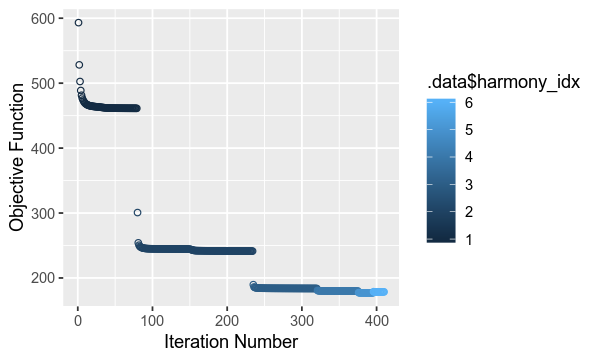

In [22]:
fig.size(3, 5)
harmony_embeddings <- HarmonyMatrix(
    pca_embeddings, 
    meta_data,
    'dataset', 
    theta=1, 
    do_pca=FALSE, 
    plot_convergence=TRUE
)

In [18]:
harmony_umap <- do_umap(harmony_embeddings)

# LISI 

In [19]:
lisi_res <- rbind(
    lisi::compute_lisi(harmony_embeddings, meta_data, c('dataset', 'cell_type')) %>% 
        dplyr::mutate(type = 'harmony'),
    lisi::compute_lisi(pca_embeddings, meta_data, c('dataset', 'cell_type')) %>% 
        dplyr::mutate(type = 'pca')
) %>% 
    tidyr::gather(key, val, cell_type, dataset)

In [20]:
head(lisi_res)


,type,key,val
,<chr>,<chr>,<dbl>
1,harmony,cell_type,1
2,harmony,cell_type,1
3,harmony,cell_type,1
4,harmony,cell_type,1
5,harmony,cell_type,1
6,harmony,cell_type,1


Warning message:
“Removed 33 rows containing non-finite values (stat_density).”


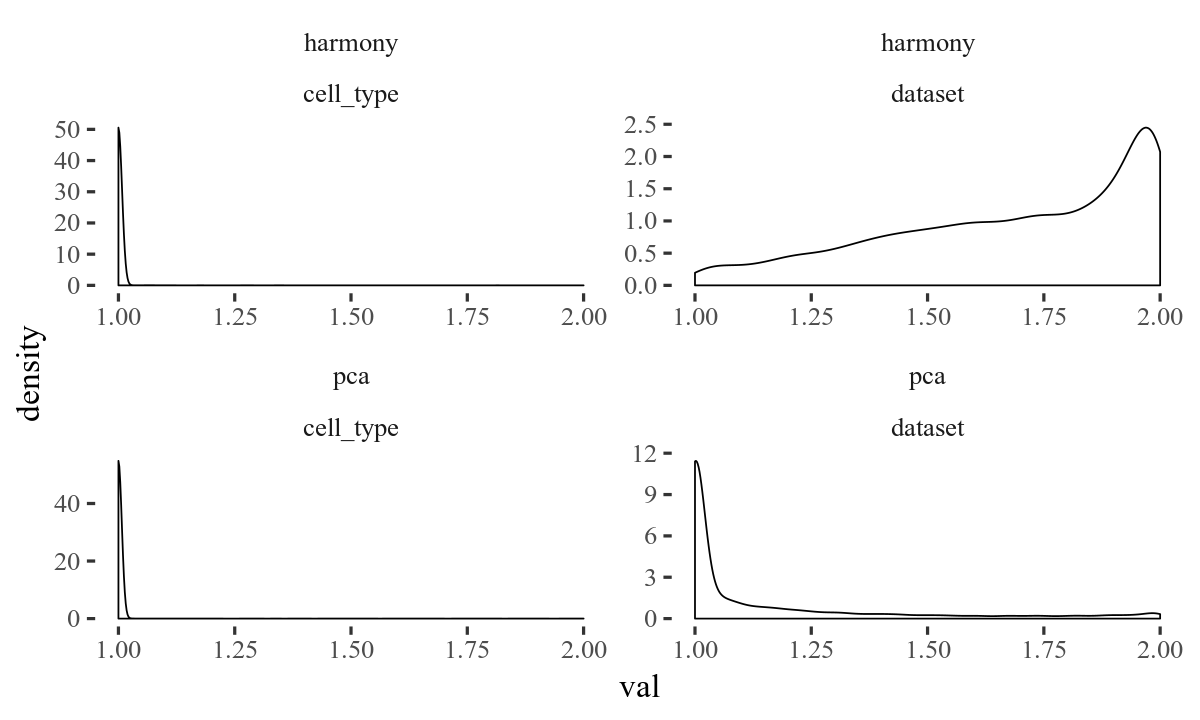

In [21]:
fig.size(6, 10)
lisi_res %>% 
    ggplot(aes(val)) + 
        geom_density() + 
        facet_wrap(~type + key, scales = 'free') + 
        theme_tufte(base_size = 20) +
        xlim(1, 2)


# Figures

In [14]:
colors_use <- c(`jurkat` = paste0("#", paste0(toupper(as.hexmode(c(129, 15, 124))), collapse = "")),
  `t293` = paste0("#", paste0(toupper(as.hexmode(c(208, 158, 45))), collapse = "")),
   `half` = paste0("#", paste0(toupper(as.hexmode(c(0, 109, 44))), collapse = "")))


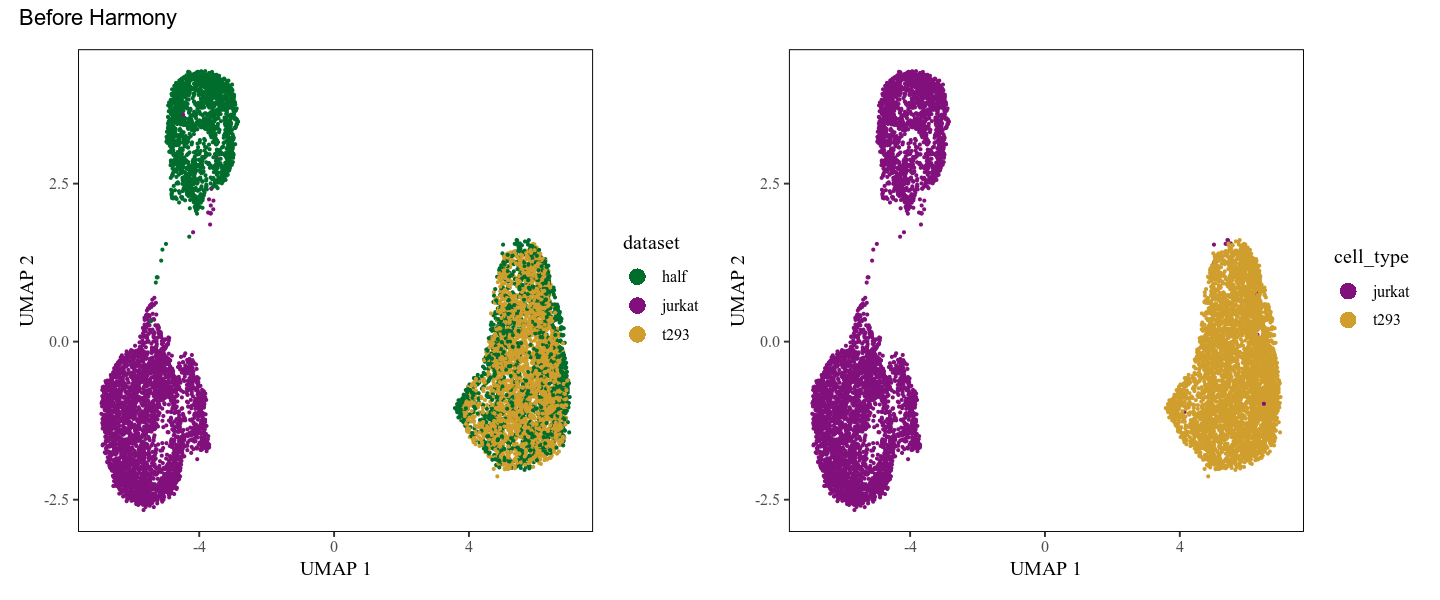

In [15]:
fig.size(5, 12)
do_scatter(pca_umap, meta_data, 'dataset', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'Before Harmony')

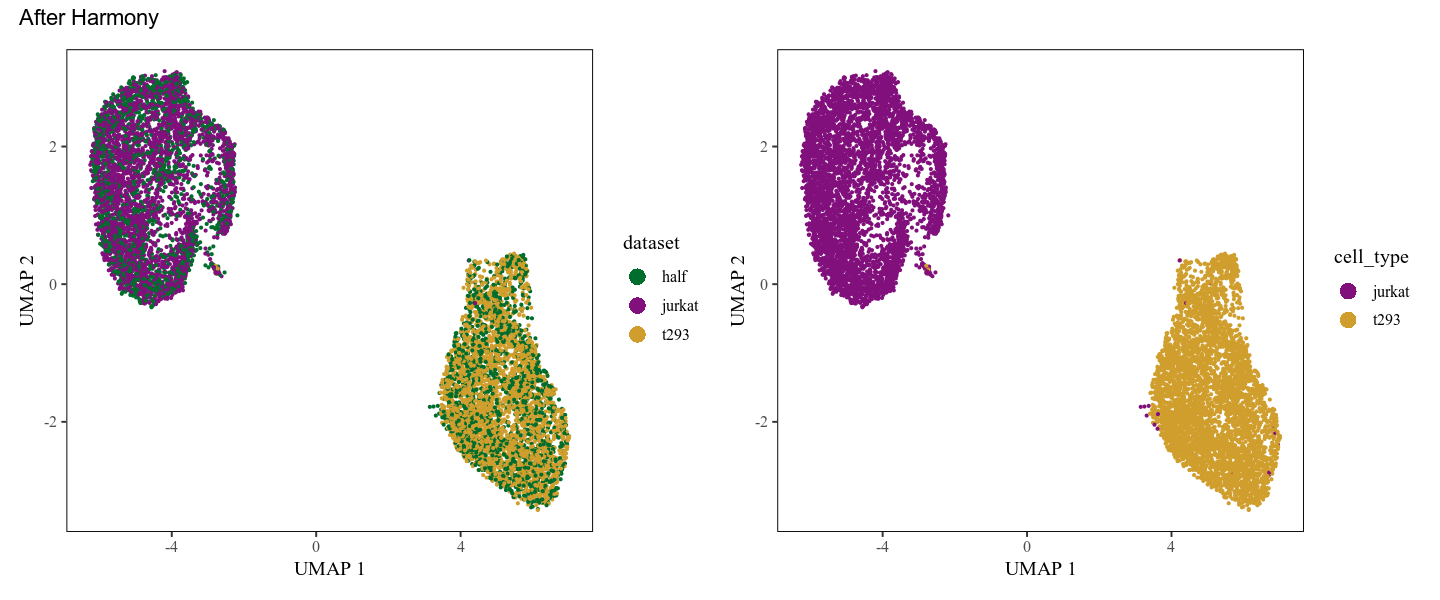

In [16]:
fig.size(5, 12)
do_scatter(harmony_umap, meta_data, 'dataset', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'After Harmony')